In [1]:
using Distributions
using Random
using LinearAlgebra
using Plots
using StatsBase
using LaTeXStrings
using ProgressBars
using ProgressMeter
using DataFrames
using CSV
using Base.Threads
using StatsPlots
using Latexify
using BenchmarkTools
gr()

Plots.GRBackend()

In [15]:
path = "/Users/nishimurarei/home/lab2/cristal/parameter_estimation/result/try_2/"

"/Users/nishimurarei/home/lab2/cristal/parameter_estimation/result/try_2/"

In [2]:
versioninfo()

Julia Version 1.6.2
Commit 1b93d53fc4 (2021-07-14 15:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i9-9980HK CPU @ 2.40GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)
Environment:
  JULIA_NUM_THREADS = 16


# モデル

In [3]:
function para_true()
    B20_true = 0.38
    B40_true = 0.16
    B44_true = 0.44
    return B20_true, B40_true, B44_true
end

para_true (generic function with 1 method)

In [4]:
function temp()
    Temp_table_chi= collect(0.2:0.2:70) # length 350
    return Temp_table_chi
end

temp (generic function with 1 method)

In [5]:
function data_num_chi()
    n_chi = 350
    return n_chi
end

data_num_chi (generic function with 1 method)

In [6]:
const n_chi = data_num_chi()

350

In [54]:
function ini()
    # Hund's Rule Ground J-Multiplet Ce3+ n4f=1
    n4f = 1.0
    L = 3.0
    S = 0.5
    J = L - S
    g = 1.0 + (J * (J + 1.0) + S * (S + 1.0) - L * (L + 1.0)) / (2.0 * J * (J + 1.0))
    Jz = [2.5, 1.5, 0.5, -0.5, -1.5, -2.5]
    return J, g, Jz
end

ini (generic function with 1 method)

In [55]:
function Onn_make(B20,B40,B44)
    # O20
    O20_vec_x = [10.0, -2.0, -8.0, -8.0, -2.0, 10.0]
    O20_vec = O20_vec_x * B20
    O20 = diagm(0 => O20_vec)
    
    # O40
    O40_vec_x = [60.0, -180.0, 120.0, 120.0, -180.0, 60.0]
    O40_vec = O40_vec_x * B40
    O40 = diagm(0 => O40_vec)

    Onn = O20 + O40
    
    # O44
    O44_value = sqrt(120.0 * 24.0) * B44 / 2.0
    Onn[5,1] = O44_value
    Onn[6,2] = O44_value
    Onn[1,5] = O44_value
    Onn[2,6] = O44_value
    
    return Onn
end

Onn_make (generic function with 1 method)

In [56]:
# 磁化率
function chi(Onn)
    _, g, Jz = ini()
    magfield = 0.01
    #magdir = [0,0,1]
    #nor_magdir = [0,0,1]
    
    # 対角要素
    Hmag_vec_0 = Jz * magfield * g * 0.67171
    Hmag = diagm(0 => Hmag_vec_0)
    
    # 非対角要素はmagdir[x,y]が0なので0
    
    # 結晶場＋磁場ハミルトニアンの行列要素
    H = Onn + Hmag
    
    eigval, eigvec = eigen(H)

    Temp_table_chi = temp()
    chi_inv_Temp = zeros(n_chi)
    
    @inbounds for (i, Temp) in enumerate(Temp_table_chi)
        eigval_2 = - eigval / Temp
        eigval_2_max = maximum(eigval_2)
        eigval_ratio = eigval_2 .- eigval_2_max
        exp_eigval = exp.(eigval_ratio)
        sumexp = sum(exp_eigval)

        mag_z = zeros(6)
        @simd for j in 1:6
            eigvec_check = eigvec[:,j]
            mag_z[j] = eigvec_check' * (eigvec_check .* Jz) * exp_eigval[j] / sumexp
        end

        Jmag_z = sum(mag_z) * g * (-1)
        Jmag = Jmag_z

        chi = Jmag / magfield * 0.5585
        chi_inv = 1.0 / chi
        chi_inv_Temp[i] = chi_inv
    end
    return chi_inv_Temp
end

chi (generic function with 1 method)

In [57]:
#ノイズ
function set_chi_noise()
    noise_chi = 1 / 10^2
    b_chi = 10^4
    return noise_chi, b_chi
end

set_chi_noise (generic function with 1 method)

In [58]:
const noise_chi, b_chi = set_chi_noise()

(0.01, 10000)

In [59]:
function making_data()
    #パラメータ真値
    B20_true, B40_true, B44_true = para_true()

    d_chi = Normal(0,noise_chi)
    chi_inv_Temp = chi(Onn_make(B20_true,B40_true,B44_true))
    chi_inv_Temp_noise = chi_inv_Temp + rand(d_chi,n_chi)
    
    return chi_inv_Temp_noise
end

making_data (generic function with 1 method)

In [60]:
#ノイズを付加した磁化率データ
const chi_inv_Temp_noise = making_data()

350-element Vector{Float64}:
  0.4686667857602634
  0.9147984231458524
  1.378974642060562
  1.806044682236009
  2.2790771551528306
  2.6904788263249317
  3.1279740872593735
  3.5433341676632093
  3.991355817974411
  4.40207978257703
  ⋮
 89.37260466944713
 89.60764684134287
 89.83329097967946
 90.10718908883604
 90.3406333092926
 90.56805072699962
 90.81225171378485
 91.08222143655222
 91.31361161663655

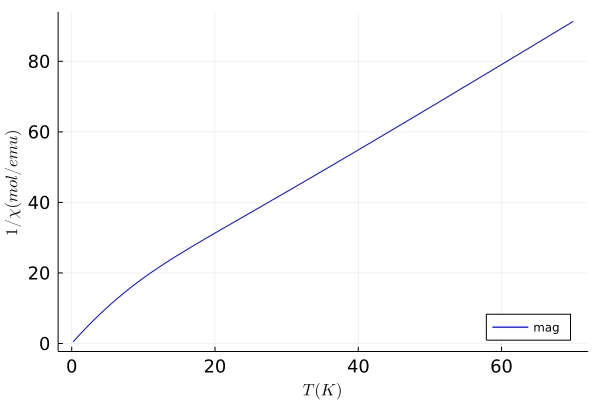

In [61]:
#chi
plot(temp(), chi_inv_Temp_noise,label="mag",color="blue")
plot!(xlabel=L"T(K)",ylabel=L"1/\chi(mol/emu)")
plot!(legendfontsize=10,xtickfont=font(12), ytickfont=font(12))
plot!(legend=:bottomright)

In [16]:
savefig(path * "chi_data.pdf")

# 逆温度

In [17]:
#レプリカ数
const L = 50

50

In [18]:
#逆温度
function make_beta(gamma,L)
    beta_list = gamma.^( (1:1:L) .- L )
    return beta_list
end

make_beta (generic function with 1 method)

In [62]:
const beta_list = make_beta(1.8, L)

50-element Vector{Float64}:
 3.102038973662444e-13
 5.583670152592399e-13
 1.005060627466632e-12
 1.8091091294399376e-12
 3.2563964329918876e-12
 5.861513579385398e-12
 1.0550724442893717e-11
 1.8991303997208692e-11
 3.418434719497564e-11
 6.153182495095616e-11
 ⋮
 0.009074442627116708
 0.016333996728810075
 0.029401194111858132
 0.05292214940134464
 0.09525986892242036
 0.17146776406035663
 0.30864197530864196
 0.5555555555555556
 1.0

# ステップサイズ

In [20]:
function step_size_make(C1,C2,d,e)
    #データ数
    n = data_num_chi()

    #一度低温領域のステップサイズをふる
    step_size_list = C1 ./ (n_chi * beta_list).^ d
    
    #高温領域のステップサイズ
    step_size_list[n * beta_list .< e] .= C2
    
    return step_size_list
end

step_size_make (generic function with 1 method)

In [63]:
const step_size_B20 = step_size_make(0.01,0.01,0.7,1)
const step_size_B40 = step_size_make(0.01,0.01,0.7,1)
const step_size_B44 = step_size_make(0.01,0.01,0.7,1)

50-element Vector{Float64}:
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 0.01
 ⋮
 0.004453263545101654
 0.002951125263505276
 0.0019556759290562677
 0.0012960033878559416
 0.0008588461699503551
 0.0005691472341431755
 0.0003771671638840179
 0.00024994423407235204
 0.00016563509798330538

# 誤差関数

In [64]:
function error_chi(B20,B40,B44)
    error_value = sum((chi_inv_Temp_noise - chi(Onn_make(B20,B40,B44))).^2)/(2*n_chi)
    return error_value
end

error_chi (generic function with 1 method)

# 事前分布

In [24]:
function cauchy(x)
    #パラメータ設定
    x_0 = 0
    gamma = 10
    
    return (1 / pi) * gamma / (gamma^2 + (x-x_0)^2)
end

cauchy (generic function with 1 method)

In [65]:
function half_cauchy(x)
    if x <= 0.0
        return 10^(-20)
    else
        #xが正のときはコーシー分布の値を返す
        x_0 = 0
        gamma = 10
        return (1 / pi) * gamma / (gamma^2 + (x-x_0)^2)
    end
end

half_cauchy (generic function with 1 method)

In [44]:
function prior(B20,B40,B44)
    return cauchy(B20) * cauchy(B40) * half_cauchy(B44)
end

prior (generic function with 1 method)

# メトロポリス

In [66]:
function metropolis_chi_B20(para_B20_ini, para_B40_ini, para_B44_ini, flag, ac_B20)
    #ステップサイズ
    para_B20_renew = para_B20_ini + rand([1,-1],L) .* step_size_B20

    #事前分布
    prior_ratio = cauchy.(para_B20_renew) ./ cauchy.(para_B20_ini)
    
    #誤差関数の差
    error_dif = error_chi.(para_B20_renew, para_B40_ini, para_B44_ini) - error_chi.(para_B20_ini, para_B40_ini, para_B44_ini)

    #更新確率
    prob = exp.(- n_chi * b_chi * beta_list .* error_dif) .* prior_ratio
    
    #更新
    bit_vec = rand(L) .< prob
    bit_flip_vec = 1 .- bit_vec 
    para_B20_return = para_B20_renew .* bit_vec + para_B20_ini .* bit_flip_vec

    #交換率記録
    if flag
        ac_B20 += bit_vec
    end

    return para_B20_return, ac_B20
end


metropolis_chi_B20 (generic function with 1 method)

In [67]:
function metropolis_chi_B40(para_B20_ini, para_B40_ini, para_B44_ini, flag, ac_B40)
    #ステップサイズ
    para_B40_renew = para_B40_ini + rand([1,-1],L) .* step_size_B40

    #事前分布
    prior_ratio = cauchy.(para_B40_renew) ./ cauchy.(para_B40_ini)
    
    #誤差関数の差
    error_dif = error_chi.(para_B20_ini, para_B40_renew, para_B44_ini) - error_chi.(para_B20_ini, para_B40_ini, para_B44_ini)

    #更新確率
    prob = exp.(- n_chi * b_chi * beta_list .* error_dif) .* prior_ratio
    
    #更新
    bit_vec = rand(L) .< prob
    bit_flip_vec = 1 .- bit_vec 
    para_B40_return = para_B40_renew .* bit_vec + para_B40_ini .* bit_flip_vec

    if flag
        ac_B40 += bit_vec
    end

    return para_B40_return, ac_B40
end


metropolis_chi_B40 (generic function with 1 method)

In [68]:
function metropolis_chi_B44(para_B20_ini, para_B40_ini, para_B44_ini, flag, ac_B44)
    #ステップサイズ
    para_B44_renew = para_B44_ini + rand([1,-1],L) .* step_size_B44

    #事前分布
    prior_ratio = half_cauchy.(para_B44_renew) ./ half_cauchy.(para_B44_ini)
    
    #誤差関数の差
    error_dif = error_chi.(para_B20_ini, para_B40_ini, para_B44_renew) - error_chi.(para_B20_ini, para_B40_ini, para_B44_ini)

    #更新確率
    prob = exp.(- n_chi * b_chi * beta_list .* error_dif) .* prior_ratio
    
    #更新
    bit_vec = rand(L) .< prob
    bit_flip_vec = 1 .- bit_vec 
    para_B44_return = para_B44_renew .* bit_vec .+ para_B44_ini .* bit_flip_vec

    if flag
        ac_B44 += bit_vec
    end

    return para_B44_return, ac_B44
end


metropolis_chi_B44 (generic function with 1 method)

In [69]:
function metropolis_chi(para_B20_ini, para_B40_ini, para_B44_ini, flag, ac_B20, ac_B40, ac_B44)
    para_B20_renew, ac_B20 = metropolis_chi_B20(para_B20_ini, para_B40_ini, para_B44_ini, flag, ac_B20)
    para_B40_renew, ac_B40 = metropolis_chi_B40(para_B20_ini, para_B40_ini, para_B44_ini, flag, ac_B40)
    para_B44_renew, ac_B44 = metropolis_chi_B40(para_B20_ini, para_B40_ini, para_B44_ini, flag, ac_B44)
    return para_B20_renew, para_B40_renew, para_B44_renew, ac_B20, ac_B40, ac_B44
end


metropolis_chi (generic function with 1 method)

# レプリカ交換

In [70]:
function exchange_chi(para_B20, para_B40, para_B44, flag, ex_rate)
    #逆温度の差
    beta_dif = beta_list[2:end] - beta_list[1:end-1]

    @inbounds @simd for replica in 1:L-1
        #交換確率
        prob = exp(n_chi * b_chi * beta_dif[replica] * (error_chi(para_B20[replica + 1], para_B40[replica + 1], para_B44[replica + 1]) - error_chi(para_B20[replica], para_B40[replica], para_B40[replica])))

        #ビット
        bit = rand() < prob # 1で交換、0で非交換

        if bit == 1 #交換
            para_B20[replica+1], para_B20[replica] = para_B20[replica], para_B20[replica+1]
            para_B40[replica+1], para_B40[replica] = para_B40[replica], para_B40[replica+1]
            para_B44[replica+1], para_B44[replica] = para_B44[replica], para_B44[replica+1]
        end

        if flag
            ex_rate[replica] += bit
        end
    end

    return para_B20, para_B40, para_B44, ex_rate
end

exchange_chi (generic function with 1 method)

# exmc

In [71]:
function initial_para_make()
    #パラメータ候補値
    para_num = collect(0.01:0.01:1.00)
    #確率
    para_prob = cauchy.(para_num)

    return sample(para_num, ProbabilityWeights(para_prob),L)
end

initial_para_make (generic function with 1 method)

In [75]:
function exmc()
    #初期パラメータ設定
    para_B20 = initial_para_make() 
    para_B40 = initial_para_make() 
    para_B44 = initial_para_make() 

    #イテレーション数
    iter_num_burn = 100000
    iter_num = 100000
    
    #mcmcの中で交換する割合
    exchange_iter = 3

    #採択率・交換率
    ac_B20 = zeros(Float16, L)
    ac_B40 = zeros(Float16, L)
    ac_B44 = zeros(Float16, L)
    ex_rate = zeros(Float16, L)

    #パラメータ
    B20_save = zeros(Float16, iter_num, L)
    B40_save = zeros(Float16, iter_num, L)
    B44_save = zeros(Float16, iter_num, L)

    #burn in
    flag_burn = false
    @threads for iter in 1:iter_num_burn
        para_B20, para_B40, para_B44, _, _, _ = metropolis_chi(para_B20, para_B40, para_B44, flag_burn, 0, 0, 0)
        if iter % exchange_iter == 0
            para_B20, para_B40, para_B44, _ = exchange_chi(para_B20, para_B40, para_B44, flag_burn, 0)
        end
    end

    #after burn in
    #burn in
    flag = true
    @threads for iter in 1:iter_num
        para_B20, para_B40, para_B44, ac_B20, ac_B40, ac_B44 = metropolis_chi(para_B20, para_B40, para_B44, flag, ac_B20, ac_B40, ac_B44)
        
        if iter % exchange_iter == 0
            para_B20, para_B40, para_B44, ex_rate = exchange_chi(para_B20, para_B40, para_B44, flag, ex_rate)
        end

        B20_save[iter,:] = para_B20
        B40_save[iter,:] = para_B40
        B44_save[iter,:] = para_B44

    end

    ac_B20 /= iter_num
    ac_B40 /= iter_num
    ac_B44 /= iter_num
    ex_rate /= (iter_num/exchange_iter)

    return B20_save, B40_save, B44_save, ac_B20, ac_B40, ac_B44, ex_rate
end


exmc (generic function with 1 method)

In [76]:
para_B20, para_B40, para_B44, ac_B20, ac_B40, ac_B44, ex_rate = exmc()

(Float16[-0.0728 -0.1946 … 0.634 0.634; -0.0828 -0.1846 … 0.634 0.634; … ; 0.1494 1.64 … 0.634 0.634; 0.1594 1.63 … 0.634 0.634], Float16[0.3567 1.325 … 0.01773 0.01772; 0.3467 1.335 … 0.01773 0.01772; … ; -1.45 0.7944 … 0.01773 0.01772; -1.46 0.804 … 0.01773 0.01772], Float16[0.3767 1.325 … 0.01773 0.01772; 0.3467 1.315 … 0.01773 0.01772; … ; -1.431 0.8145 … 0.01773 0.01772; -1.46 0.784 … 0.01773 0.01772], Float16[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float16[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float16[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.061439999999999995, 0.061439999999999995, 0.061439999999999995, 0.061439999999999995, 0.061439999999999995, 0.061439999999999995, 0.061439999999999995, 0.061439999999999995, 0.061439999999999995, 0.061439999999999995  …  0.00066, 0.061439999999999995